# Modeling and Simulation in Python

Chapter 15

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### The coffee cooling problem

I'll use a `State` object to store the initial temperature.


In [2]:
init = State(T=90)

,values
T,90


And a `System` object to contain the system parameters.

In [3]:
coffee = System(init=init,
                volume=300,
                r=0.01,
                T_env=22,
                t_0=0,
                t_end=30,
                dt=1)

,values
init,T 90 dtype: int64
volume,300
r,0.01
T_env,22
t_0,0
t_end,30
dt,1


The update function implements Newton's law of cooling.

In [4]:
def update_func(state, t, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    r, T_env, dt = system.r, system.T_env, system.dt
    
    T = state.T
    T += -r * (T - T_env) * dt
    
    return State(T=T)

Here's how it works.

In [5]:
update_func(init, 0, coffee)

,values
T,89.32


Here's a version of `run_simulation` that uses `linrange` to make an array of time steps.

In [6]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

And here's how it works.

In [7]:
results = run_simulation(coffee, update_func)

,T
0,90
1,89.32
2,88.6468
3,87.9803
4,87.3205
5,86.6673
6,86.0207
7,85.3804
8,84.7466
9,84.1192


Here's what the results look like.

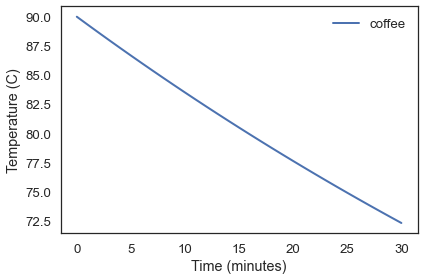

In [8]:
plot(results.T, label='coffee')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

And here's the final temperature:

In [9]:
coffee.T_final = get_last_value(results.T)
T_final = get_last_value(results.T)

72.2996253904031

## Encapsulation

Before we go on, let's define a function to initialize `System` objects with relevant parameters:

In [12]:
def make_system(T_init, r, volume, t_end):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(T=T_init)
                   
    return System(init=init,
                  r=r, 
                  volume=volume,
                  temp=T_init,
                  t_0=0, 
                  t_end=t_end, 
                  dt=1,
                  T_env=22)

Here's how we use it:

In [13]:
coffee = make_system(T_init=90, r=0.01, volume=300, t_end=30)
results = run_simulation(coffee, update_func)
T_final = get_last_value(results.T)

72.2996253904031

## Exercises

**Exercise:**  Simulate the temperature of 50 mL of milk with a starting temperature of 5 degC, in a vessel with the same insulation, for 15 minutes, and plot the results.

By trial and error, find a value for `r` that makes the final temperature close to 20 C.

final tmep:7.379007971098095


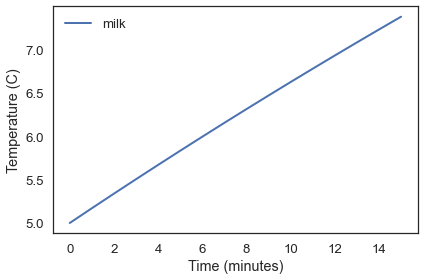

In [16]:
coffee = make_system(T_init=5, r=0.01, volume=50, t_end=15)
results = run_simulation(coffee, update_func)
T_final = get_last_value(results.T)

print (f'final tmep:{T_final}')

plot(results.T, label='milk')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

In [25]:
r = 0.01
rate = 0.5
error = 1.0
steps = 1
target = 20

# Loop to search for optimal value for r giving a target of 20C
while abs(error) > 0.01 and steps < 100:
    coffee = make_system(T_init=5, r=r, volume=50, t_end=15)
    results = run_simulation(coffee, update_func)
    T_final = get_last_value(results.T)
    
    # calculate our error (simple difference)
    error = T_final - target
    print(f'step:{steps}, r:{r}, t:{T_final}, error:{error}')
    
    # if the error is negative, we need to continue increasing R,
    # if the error is positive, we've overshot and need to back up some
    if error < 0:
        r += rate
    else:
        r -= rate
        
    # Each step we decrease the rate by half - this should quickly narrow in on an optimum
    rate = rate * 0.5
    
    # count out steps just in cases to prevent an infinite loop
    steps += 1


step:1, r:0.01, t:7.379007971098095, error:-12.620992028901906
step:2, r:0.51, t:21.999616831215057, error:1.9996168312150573
step:3, r:0.26, t:21.814251755759834, error:1.8142517557598339
step:4, r:0.135, t:20.069407861638226, error:0.06940786163822565
step:5, r:0.07250000000000001, t:16.50259547369692, error:-3.497404526303079
step:6, r:0.10375000000000001, t:18.712343378034348, error:-1.2876566219656524
step:7, r:0.11937500000000001, t:19.474693607024776, error:-0.5253063929752244
step:8, r:0.1271875, t:19.79065630371931, error:-0.2093436962806905
step:9, r:0.13109375, t:19.93441658557982, error:-0.06558341442017834
step:10, r:0.133046875, t:20.002976538076997, error:0.0029765380769966043
